<a href="https://colab.research.google.com/github/ruperty/colab/blob/master/moving_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moving Cartpole

This demonstration follows on from an initial application of Perceptual Control Theory to the inverted pendulum problem at https://colab.research.google.com/github/ruperty/colab/blob/master/basic_cartpole.ipynb.

With PCT it is quite straightforward to move the whole Cartpole system around. One way to do this is to change the reference of the high lever goal of pole angle. Just changing this will drive the cartpole around by changing the lower level goals such as the cart position. In other words, they will no longer be zero.

However, there is a limitation with the existing hierarchy in that the cart pole can only go so far due to all the control levels being just proportional controllers.

Let's see why, by running the previous system and introducing a pole angle reference of 10 degrees.

By the way, in terms of position, the centre of the environment has a value of zero. To the left is negative and to the right is positive.

A few installs and imports first though.

In [1]:
# install of utilities to display openai environment in video
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils  > /dev/null 2>&1

In [2]:
# install of my own pct library
!git clone https://github.com/ruperty/pct.git

Cloning into 'pct'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 486 (delta 0), reused 2 (delta 0), pack-reused 481
Receiving objects: 100% (486/486), 163.60 KiB | 9.09 MiB/s, done.
Resolving deltas: 100% (288/288), done.


In [4]:
# library imports
import gym
import math
import pct.plots as plots
from pct.openai.cpplots import CartpoleControlPlots
import pct.openai.utils as ou
import pct.utilities.rmath as rm
import pct.openai.video  as vid
from pct.utilities.errors import root_sum_squared_error
from gym.wrappers import Monitor
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start() 

Okay, imports done, so let's define again the PCT controller for balancing.

In [9]:
def controller(ctr, pole_angle_ref, state, gains, figures, serror, sum_error_ma, sfactor, prev_power):
    action =1
    cart_position,    cart_velocity ,    pole_angle , pole_velocity =ou.get_obs(state)
    pole_angle_gain,pole_velocity_gain,cart_position_gain,cart_velocity_gain = ou.get_gains(gains)
    
    pole_velocity_ref,pole_angle_error=proportional(pole_angle_ref, pole_angle, pole_angle_gain)
    cart_position_ref,pole_velocity_error=proportional(pole_velocity_ref, pole_velocity, pole_velocity_gain)
    cart_velocity_ref,cart_position_error=proportional(cart_position_ref, cart_position, cart_position_gain)
    power,cart_velocity_error=proportional(cart_velocity_ref, cart_velocity, cart_velocity_gain)
    power= rm.smooth(power, prev_power, 0.8)
    if power>=0:
        action=0
        
    sum_error = pole_angle_error+pole_velocity_error+cart_position_error+cart_velocity_error
    sum_error_ma=rm.smooth( sum_error, sum_error_ma, sfactor) 
    
    error=root_sum_squared_error([pole_angle_error,pole_velocity_error,cart_position_error,cart_velocity_error])
    serror=rm.smooth( error, serror, sfactor) 
    
    figures.add_points( ctr, pole_angle_ref, pole_angle, pole_velocity_ref, pole_velocity, 
                   cart_position_ref, cart_position, cart_velocity_ref, cart_velocity, action, sum_error_ma, serror)
       

    return action, serror, sum_error_ma, power

def proportional(r, p, g):
    e=r-p
    return e*g,e



Some configuration parameters, which you can change later if you like to see the effect of different values. 

In [10]:
#  the gains for each control level
gains= [ 3, 2, 1, 0.1]
pole_angle_gain = gains[0]
pole_velocity_gain = gains[1]
cart_position_gain = gains[2]
cart_velocity_gain = gains[3]
# the initial and subsequent pole angle references
pole_angle_ref = 0
pole_angle_ref_2nd = 0.175 # 10 degrees
# number of iterations
size = 750

Now let's initialise the Cartpole environment and some stuff for plotting results.

In [11]:
genv = gym.make("CartPole-v1")
genv._max_episode_steps = 4000
env = vid.wrap_env(genv)
state = env.reset()
sub_title = " gains {0:1.2f}_{1:1.2f}_{2:1.2f}_{3:1.2f}".format(pole_angle_gain,pole_velocity_gain,cart_position_gain,cart_velocity_gain)
units_figures=CartpoleControlPlots(sub_title, 1000, 1200)
reward = 0
rms_error_ma=0
sum_error_ma=0
prev_power=0

Here is the main control loop. A third of the way through the high level goal of the pole angle reference will change to 10 degrees and the cartpole will move. After another third it will change back to zero.

Watch the generated video.  

In [12]:
for ctr in range(size):
    env.render()
    if ctr == 250: pole_angle_ref=pole_angle_ref_2nd
    if ctr == 500: pole_angle_ref=0
    action, rms_error_ma, sum_error_ma, prev_power = controller(ctr, pole_angle_ref, state, gains, 
        units_figures, rms_error_ma, sum_error_ma, 0.99, prev_power)
        
    observation =env.step(action)    
    state = observation[0]
    reward+=observation[1]
    done = observation[2]

    if done: 
        print(observation)
        break

print("Reward ", reward)    
print("RMS Error %1.2f" %( rms_error_ma))  
print("Sum Error %1.2f" %( sum_error_ma))  
env.close()
vid.show_video()

Reward  750.0
RMS Error 0.72
Sum Error 0.00


Now plot the results of the control episode.


In [13]:
units_figures.figure.add_data()
units_figures.figure.getFigure()

You will notice from the above video that the even though the pole angle reference is not zero (10 degrees) the cart only moves so far then stops. This is because the cart position reference is determined by the error of the level above, which in turn is determined by the one above that.

In other words, the cart can only move to another position while there is error in the system. And there is a maximum position based upon the error. 

Looking at the graphs above you can calculate the cart position based on the top-level reference and the gains of the pole angle and pole velocity levels:

0.175 x 3 x 2 = 1.05

Look at the cart position graph at around iteration 400 and that should be the position you see.

# Move Anywhere

The cart can not move any further than that value, given the structure of the control systems. However, there is quite a simple resolution that will allow the cartpole to move any distance.

That is, to introduce an integrating, rather than proportional, control unit, at the level above the cart position controller. This means that error from the pole velocity level adds to the cart position reference rather than forming it proportionally.

# Integrating Controller

The controller below is pretty much the same as the one above except that it has an integrator controller at the pole velocity level.

It also has a pole position controller above the pole angle controller which allows us to set a high level position reference. The error from the pole position level sets a reference for the pole angle.

In [20]:

def moving_controller(ctr, pole_position_ref, state, gains, slow, figures, position_figure, serror, sfactor, scale, prev_power, plot):
    action =1
    cart_position,    cart_velocity ,    pole_angle , pole_velocity =ou.get_obs(state)        
    pole_position_gain, pole_angle_gain,pole_velocity_gain,cart_position_gain,cart_velocity_gain = ou.get_gains(gains)

    pole_position=cart_position+math.sin(pole_angle)
    pole_angle_ref,pole_position_error=sigmoid(pole_position_ref, pole_position, pole_position_gain, scale)
    
    pole_velocity_ref,pole_angle_error=proportional(pole_angle_ref, pole_angle, pole_angle_gain)
    cart_position_ref,pole_velocity_error=integrator(pole_velocity_ref, pole_velocity, pole_velocity_gain, slow, cart_position)
    cart_velocity_ref,cart_position_error=proportional(cart_position_ref, cart_position, cart_position_gain)
    power,cart_velocity_error=proportional(cart_velocity_ref, cart_velocity, cart_velocity_gain)
    power= rm.smooth(power, prev_power, 0.75)
    if power>=0:
        action=0
        
    error=root_sum_squared_error([pole_angle_error,pole_velocity_error,cart_position_error,cart_velocity_error])
    serror=rm.smooth( error, serror, sfactor) 
    if plot:
        if type(figures)==go.FigureWidget:
            add_cartpolepoints_to_widget(figures, 2, ctr, pole_angle_ref, pole_angle, pole_velocity_ref, pole_velocity, 
                       cart_position_ref, cart_position, cart_velocity_ref, cart_velocity, action, error, serror)        
        else:    
            figures.add_points( ctr, pole_angle_ref, pole_angle, pole_velocity_ref, pole_velocity, 
                       cart_position_ref, cart_position, cart_velocity_ref, cart_velocity, action, error, serror)
        
        if type(position_figure)==go.FigureWidget:        
            add_cartpole_positions_to_widget(position_figure, ctr, pole_position_ref, pole_position)
        else:    
            position_figure.add_points( ctr, pole_position_ref, pole_position)

    return action, serror, pole_position, power

def sigmoid(r, p, g, scale):
    e=r-p
    return rm.sigmoid( e, g, scale),e

def integrator(r, p, g, s, o):
    e=r-p
    o +=  (g * e - o) / s;
    return o,e


First the configuration.

You can change some of these later if you like.

In [21]:
# gains
gains= [0.45, 1.5, 90, 2, 0.1]
slow = 100
pole_position_gain= gains[0]
pole_angle_gain = gains[1]
pole_velocity_gain = gains[2]
cart_position_gain = gains[3]
cart_velocity_gain = gains[4]
pole_position_ref = 0
loops = 1700

Some settings. I wouldn't change these.

In [22]:
# some settings and plots
from pct.openai.cpplots import CartpolePositionPlot
import plotly.graph_objs as go
reward = 0
sub_title = " gains {0:1.2f}_{0:1.2f}_{1:1.2f}_{2:1.2f}_{3:1.2f}".format(pole_position_gain, pole_angle_gain,pole_velocity_gain,cart_position_gain,cart_velocity_gain)
units_figures=CartpoleControlPlots(sub_title, 1000, 1200)
position_figure=CartpolePositionPlot(1000, 600)
serror=0
prev_power=0
plot=True
sfactor=.99
scale=2

Create the OpenAI Cartpole environment.

In [23]:
# create the environment
genv = gym.make("CartPole-v1")
genv._max_episode_steps = 4000
env = vid.wrap_env(genv)
state = env.reset()

# Run It!

At last, we can now do the fun bit and run the system to balance the pole with the cart.

The next cell executes the system for a number of loops and runs the controller to maintain the balanced pole. It also, a number of times, changes the high level reference for the desired position of the pole.

The result is that the cartpole system is able to move about at will.

So, run the next cell and a video will be produced that shows the cartpole moving about while keeping the pole balanced.


In [24]:
for ctr in range(loops):
    env.render()
        
    if ctr == 100  :  pole_position_ref= 2
    if ctr == 350  :  pole_position_ref= -2
    if ctr == 850   :  pole_position_ref= 2
    if ctr == 1350 :  pole_position_ref= 0

    action, serror, pole_position, prev_power = moving_controller(ctr, pole_position_ref, state, gains, 
        slow, units_figures, position_figure, serror, sfactor,  scale, prev_power, plot)
        
    observation =env.step(action)    
    state = observation[0]
    reward+=observation[1]
    done = observation[2]

    if done: 
        print(observation)
        break
 
print("Reward ", reward)    
print("Error %1.2f" %( serror))  
print("Pole position %1.3f" %( pole_position))  

env.close()
vid.show_video()

Reward  1700.0
Error 0.39
Pole position -0.005


Have a look at the graphs in the next cell.

In contrast to the graphs for the purely proportional control system above you will see that errors come to zero evern when the cart is not at the centre (zero) position.

For example, have a look at iteration 800. The position of the cart is at -2, yet the pole angle reference is zero (as is the actual value). At each level of the hierarchy the error (the difference between the reference and actual value) is zero, more or less. 

In [25]:
units_figures.figure.add_data()
units_figures.figure.getFigure()

There is one other control unit we haven't looked at yet. The one we added at the top, which is the pole position controller. This is controlling the lateral position of the tip of the pole. It does so by dynamically setting reference goals for the lower levels and, ultimately, the position of the cart on which it is intimately dependent.

As you can see, as the goal changes the system moves to realise that goal very effectively.

Incidentally, you may have noticed, in the controller code above, that this level is a "sigmoid" controller rather than a proportional controller. Essentially these are the same except that the sigmoid limits the output to  minimum and maximum values.  This is just to ensure that the pole angle requested is kept below large values at which it would topple. This way of limiting the output of a control unit is quite consistent with natural systems, and the beahviour of neural systems.  


In [26]:
position_figure.figure.add_data()
position_figure.figure.getFigure()

# Real Robot

So, there it is, how an inverted pendulum system can move about as it likes.

This is not just a theoretical or simulated system, it actually works in real life.

Here is this system implemented on a real robot, one that can even stand up by itself, and on a high-speed train!

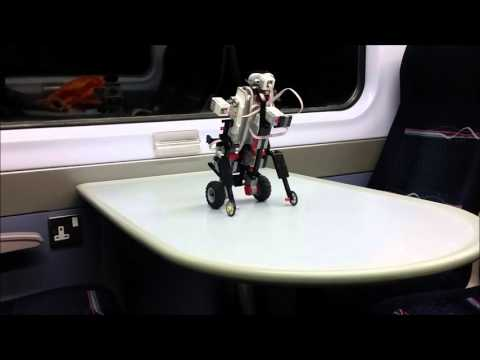

In [27]:
from IPython.display import YouTubeVideo
YouTubeVideo('FCPDEeosCPU', width=500)

# What Next?

This system works pretty well, but it is a little bit shaky. The gain values have been chosen by hand which is quite a laborious way to find the best values.

The next step is to optimise those gain values using automatic reorganisation through some process of machine learning.